# Analysis of HAN SPAD results



In [46]:
# Imports
import os
import sys
sys.path.append(os.path.dirname(os.path.abspath('')))
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as ticker

from scipy.stats import pearsonr
import pingouin as pg

from lib.analysis_tools import plot_boxes_grade_cats

In [47]:
# Load ABT, cleanup and concatenate
abt = pd.read_csv('data/han_spad_abt.csv')
abt

,assignment,file,kloc,submission_date,grade,subgrade_datatypes,subgrade_methods,subgrade_control_structures,subgrade_events,subgrade_coding_standard,...,checkstyle_NestedForDepth,checkstyle_NestedIfDepth,checkstyle_ParameterAssignment,checkstyle_ParameterNumber,checkstyle_ReturnCount,checkstyle_SimplifyBooleanExpression,checkstyle_SimplifyBooleanReturn,checkstyle_UnusedLocalVariable,checkstyle_VariableDeclarationUsageDistance,checkstyle_VisibilityModifier
0,HAN SPAD,aGFzaDg1NzE4NjQ2OTU5MDg3NDcyNTk=,0.905,2019-10-31,8.5,10.0,8.0,10.0,10.0,8.0,...,1.104972,0.000000,0.000000,0.000000,0.000000,25.414365,0.000000,0.0,2.209945,55.248619
1,HAN SPAD,aGFzaC0yNzM0NTA5Nzk1MjQwNjY0Mjk5,0.994,2019-11-01,7.0,8.0,8.0,8.0,8.0,8.0,...,0.000000,3.018109,0.000000,0.000000,3.018109,0.000000,0.000000,0.0,0.000000,55.331992
2,HAN SPAD,aGFzaDE2Mzc4OTM3Nzk1MTg4NDY4MjY=,0.492,2019-11-01,7.4,8.0,8.0,8.0,8.0,8.0,...,0.000000,4.065041,0.000000,0.000000,0.000000,0.000000,4.065041,0.0,0.000000,93.495935
3,HAN SPAD,aGFzaC0zNzAwMjU4OTk1NTE5MzQ2ODQy,0.448,2019-10-30,8.2,8.0,8.0,10.0,6.0,8.0,...,2.232143,0.000000,22.321429,4.464286,4.464286,0.000000,0.000000,0.0,2.232143,31.250000
4,HAN SPAD,aGFzaDgzMTY2MjQwNjA2Nzk3MzA4ODU=,0.468,2019-11-01,7.9,8.0,8.0,8.0,8.0,8.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,2.136752,0.000000,0.0,6.410256,68.376068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
692,HAN SPAD,aGFzaDcyODI4NjU0MTY5NDQxNTE1MzU=,0.334,2022-12-09,1.0,6.0,1.0,6.0,6.0,4.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,59.880240
693,HAN SPAD,aGFzaDIyODgzMDAzOTEzNjUzNzkwMDE=,0.268,2022-12-09,1.0,6.0,3.5,6.0,6.0,6.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,41.044776
694,HAN SPAD,aGFzaC0xNzA1MTkxMjYwOTA5OTU2NzU2,0.619,2022-12-09,5.1,6.0,6.0,6.0,6.0,6.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,9.693053,95.315024
695,HAN SPAD,aGFzaDcwODAzNDgwMDI3MzIyMTU1NzU=,0.385,2022-12-09,1.0,6.0,6.0,6.0,8.0,4.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,83.116883


# Cleanup

In [48]:
print(f"Number of assignments total: {abt['grade'].count()} ")
print(f"Number of assignments with a grade of zero: {abt[abt['grade'] < 1]['grade'].count()}")
print(f"Number of assignments where no errors could be detected: {abt[abt['errors_total'] == 0]['grade'].count()}")
# abt[abt['errors_total'] == 0]

abt_clean = abt[(abt['grade'] >= 1) & (abt['errors_total'] > 0)].reset_index(drop = True).copy()

print(f"Number of assignments after cleanup: {abt_clean['grade'].count()}")


# NaNs are metrics that were not found for a specific assignment. Just set them to 0
abt_clean = abt_clean.fillna(0)


Number of assignments total: 697 
Number of assignments with a grade of zero: 35
Number of assignments where no errors could be detected: 4
Number of assignments after cleanup: 658


In [49]:
# Process subgrades. Calculate a final grade based on these subgrades only.
# This grade is the part of the grade that is related to code quality only.
def calculate_grade_cs(row):
    sg_weights = {
        'subgrade_datatypes' : 0.075,
        'subgrade_methods' : 0.184,
        'subgrade_control_structures' : 0.075,
        'subgrade_events' : 0.075,
        'subgrade_coding_standard' : 0.092,
        'subgrade_repeating_code': 0.092,
        'subgrade_decomposition' : 0.092,
    }
    grade_cq = 0
    sum_weights = 0
    for sg, weight in sg_weights.items():
        grade_cq += row[sg] * weight
        sum_weights += weight
    # Scale to full grade
    return grade_cq / sum_weights

abt_clean['grade_cq'] = abt_clean.apply(calculate_grade_cs, axis = 1)


In [50]:

# Drop columns for subgrades
abt_clean = abt_clean.drop([x for x in abt_clean.columns if x.startswith('subgrade')],axis = 1)

# Failing grades are distributed unevenly because they contain knockout values.
# Set all of them to 5.0 if they're lower than 5.0
abt_clean.grade = abt_clean['grade'].map(lambda x : 5.0 if x < 5.0 else x)
# Do the same for cs only grades
abt_clean.grade_cq = abt_clean['grade_cq'].map(lambda x : 5.0 if x < 5.0 else x)


In [51]:

# Only retain columns for categories, clusters and totals.
abt_final = abt_clean[['grade', 'grade_cq',
                       'errors_count',
                       'errors_total'] + [x for x in abt_clean.columns if x.startswith('cluster_') ] +
                       ['pmd_count',
                       'pmd_total'] + [x for x in abt_clean.columns if x.startswith('pmd_cat_')] +
                       ['checkstyle_count',
                        'checkstyle_total'] + [x for x in abt_clean.columns if x.startswith('checkstyle_cat_')]].reset_index(drop = True).copy()

# Additionally, create columns for the categories teachers were
# questioned about.
abt_final['cat_Code style'] = abt_final['pmd_cat_Code style'].copy()
abt_final['cat_Design'] = abt_final['pmd_cat_Design'] + abt_final['checkstyle_cat_Class Design']
abt_final['cat_ErrorProne'] = abt_final['pmd_cat_ErrorProne'].copy()
abt_final['cat_SizeViolations'] = abt_final['checkstyle_cat_SizeViolations'].copy()


In [52]:
# When graphing box plots, normalize values between 0 and 1
must_normalize = False

if must_normalize:
    for x in abt_final.columns:
        if x == 'grade':
          continue
        abt_final[x] = abt_final[x] / abt_final[x].max()
abt_final

,grade,grade_cq,errors_count,errors_total,cluster_Best practices,cluster_Complexity,cluster_Incomplete code,cluster_Reusability and extendibility,cluster_Side effects,pmd_count,...,checkstyle_cat_Block Checks,checkstyle_cat_Class Design,checkstyle_cat_Coding,checkstyle_cat_Imports,checkstyle_cat_Metrics,checkstyle_cat_SizeViolations,cat_Code style,cat_Design,cat_ErrorProne,cat_SizeViolations
0,8.5,7.851095,34.254144,537.016575,121.546961,6.629834,67.403315,341.436464,0.000000,19.889503,...,0.000000,169.060773,198.895028,4.419890,5.524862,3.314917,104.972376,204.419890,1.104972,3.314917
1,7.0,6.925547,47.283702,588.531187,182.092555,9.054326,22.132797,375.251509,0.000000,32.193159,...,0.000000,132.796781,264.587525,7.042254,3.018109,0.000000,136.820926,152.917505,9.054326,0.000000
2,7.4,6.925547,56.910569,575.203252,178.861789,10.162602,71.138211,315.040650,0.000000,34.552846,...,6.097561,176.829268,162.601626,8.130081,4.065041,0.000000,168.699187,213.414634,0.000000,0.000000
3,8.2,6.925547,98.214286,870.535714,381.696429,22.321429,55.803571,372.767857,37.946429,55.803571,...,0.000000,116.071429,343.750000,8.928571,11.160714,4.464286,314.732143,145.089286,4.464286,4.464286
4,7.9,6.925547,49.145299,722.222222,243.589744,10.683761,115.384615,350.427350,2.136752,29.914530,...,0.000000,151.709402,271.367521,8.547009,4.273504,0.000000,262.820513,173.076923,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
653,6.6,6.487591,57.613169,1030.864198,224.279835,12.345679,94.650206,699.588477,0.000000,30.864198,...,0.000000,183.127572,549.382716,8.230453,10.288066,2.057613,218.106996,236.625514,0.000000,2.057613
654,5.0,5.000000,77.844311,910.179641,140.718563,32.934132,62.874251,673.652695,0.000000,44.910180,...,0.000000,113.772455,580.838323,11.976048,26.946108,2.994012,119.760479,158.682635,2.994012,2.994012
655,5.0,5.059854,67.164179,585.820896,97.014925,0.000000,63.432836,425.373134,0.000000,37.313433,...,0.000000,123.134328,324.626866,14.925373,0.000000,0.000000,100.746269,130.597015,0.000000,0.000000
656,5.1,5.731387,37.156704,605.815832,177.705977,8.077544,58.158320,361.873990,0.000000,21.001616,...,0.000000,158.319871,232.633279,6.462036,3.231018,0.000000,176.090468,184.168013,0.000000,0.000000


# Distribution of grades

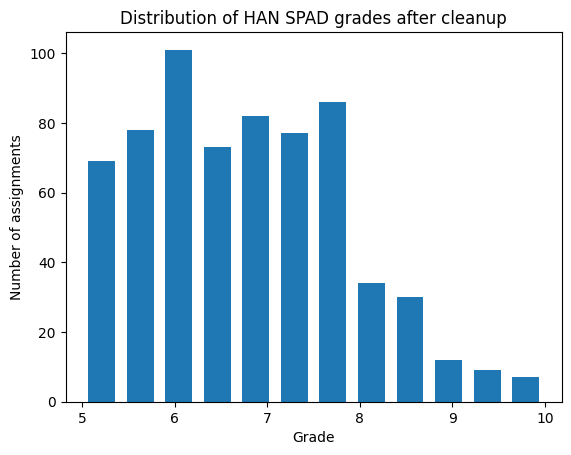

In [53]:
ax = abt_final['grade'].hist(bins=12, rwidth = 0.7)
ax.grid(False)
ax.set_xlabel('Grade')
ax.set_ylabel('Number of assignments')
ax.set_title('Distribution of HAN SPAD grades after cleanup')
plt.show()

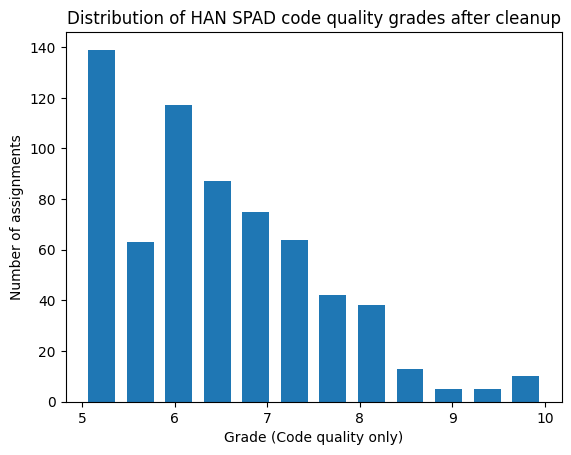

In [54]:
ax = abt_final['grade_cq'].hist(bins=12, rwidth = 0.7)
ax.grid(False)
ax.set_xlabel('Grade (Code quality only)')
ax.set_ylabel('Number of assignments')
ax.set_title('Distribution of HAN SPAD code quality grades after cleanup')
plt.show()

## Distribution of failing grades before cleanup

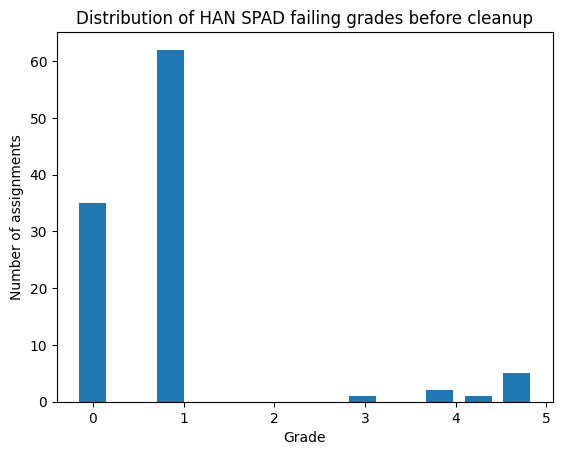

In [55]:
ax = abt[abt['grade'] < 5.5]['grade'].hist(
    bins = 12, 
    rwidth = 0.7, 
    align="left")
ax.grid(False)
ax.set_xlabel('Grade')
ax.set_ylabel('Number of assignments')
ax.set_title('Distribution of HAN SPAD failing grades before cleanup')
plt.show()

# Correlations

## Correlations for all grades

In [56]:
corr = abt_final.corr(method='spearman') # Spearman to correct for non-normal distribution. Effect is very small, however.
corr.style.background_gradient(cmap='coolwarm')

,grade,grade_cq,errors_count,errors_total,cluster_Best practices,cluster_Complexity,cluster_Incomplete code,cluster_Reusability and extendibility,cluster_Side effects,pmd_count,pmd_total,pmd_cat_Best practices,pmd_cat_Code style,pmd_cat_Design,pmd_cat_ErrorProne,checkstyle_count,checkstyle_total,checkstyle_cat_Block Checks,checkstyle_cat_Class Design,checkstyle_cat_Coding,checkstyle_cat_Imports,checkstyle_cat_Metrics,checkstyle_cat_SizeViolations,cat_Code style,cat_Design,cat_ErrorProne,cat_SizeViolations
grade,1.000000,0.810455,-0.318470,-0.207122,0.197437,-0.104996,-0.184905,-0.294493,0.209131,-0.283272,0.125738,0.118314,0.145822,-0.083163,0.142715,-0.341594,-0.296410,-0.108532,-0.086669,-0.238669,-0.377402,-0.125474,0.005285,0.145822,-0.109928,0.142715,0.005285
grade_cq,0.810455,1.000000,-0.260271,-0.192235,0.222172,-0.181402,-0.139961,-0.283224,0.188701,-0.194324,0.181989,0.143227,0.216013,-0.087656,0.127295,-0.327335,-0.299205,-0.089890,-0.018411,-0.256479,-0.295751,-0.207790,-0.097474,0.216013,-0.056687,0.127295,-0.097474
errors_count,-0.318470,-0.260271,1.000000,0.329565,0.147012,0.032138,0.421663,0.197608,0.010555,0.970030,0.259599,0.067870,0.186305,0.125211,-0.023349,0.949096,0.242186,0.101857,0.186478,0.148692,0.890924,0.071408,-0.110549,0.186305,0.214290,-0.023349,-0.110549
errors_total,-0.207122,-0.192235,0.329565,1.000000,0.371851,0.205434,0.351813,0.772271,-0.005050,0.275550,0.374734,-0.048599,0.327428,0.185699,-0.014262,0.373551,0.836818,0.017695,0.123468,0.716806,0.253978,0.230815,0.169802,0.327428,0.181881,-0.014262,0.169802
cluster_Best practices,0.197437,0.222172,0.147012,0.371851,1.000000,-0.148119,0.240157,-0.121993,0.161206,0.173659,0.899571,0.080936,0.892086,0.149888,0.169878,0.097517,-0.055212,-0.041460,0.271254,-0.131868,0.033058,-0.146174,-0.032847,0.892086,0.273407,0.169878,-0.032847
cluster_Complexity,-0.104996,-0.181402,0.032138,0.205434,-0.148119,1.000000,-0.112846,0.246513,-0.044249,-0.070535,-0.206675,-0.028244,-0.333456,0.231281,0.145524,0.160681,0.337596,0.045506,-0.381798,0.413545,-0.179787,0.882835,0.552240,-0.333456,-0.205337,0.145524,0.552240
cluster_Incomplete code,-0.184905,-0.139961,0.421663,0.351813,0.240157,-0.112846,1.000000,0.005526,0.023385,0.406126,0.502769,-0.112236,0.352478,0.648426,-0.108399,0.405426,0.117354,0.046531,0.379949,-0.036680,0.408235,-0.056551,-0.107245,0.352478,0.583315,-0.108399,-0.107245
cluster_Reusability and extendibility,-0.294493,-0.283224,0.197608,0.772271,-0.121993,0.246513,0.005526,1.000000,-0.146441,0.145884,-0.156952,-0.077162,-0.138379,-0.069121,-0.086751,0.250594,0.959085,0.021567,-0.022081,0.895672,0.202387,0.260971,0.138036,-0.138379,-0.036637,-0.086751,0.138036
cluster_Side effects,0.209131,0.188701,0.010555,-0.005050,0.161206,-0.044249,0.023385,-0.146441,1.000000,0.020970,0.182838,0.462265,0.156707,-0.046895,0.004039,-0.008945,-0.104790,-0.059134,-0.015257,-0.078217,-0.109707,-0.033418,-0.002085,0.156707,-0.029688,0.004039,-0.002085
pmd_count,-0.283272,-0.194324,0.970030,0.275550,0.173659,-0.070535,0.406126,0.145884,0.020970,1.000000,0.297711,0.129530,0.225363,0.099558,0.030039,0.848002,0.167918,0.091158,0.231438,0.072123,0.871174,-0.051658,-0.201846,0.225363,0.239313,0.030039,-0.201846


In [57]:
pearson_vals = []
pd.reset_option('display.float_format')
# pd.options.display.float_format = '{:,.4f}'.format
for cat in abt_final.columns.to_numpy():
    if cat == 'grade' or cat == 'grade_cq':
        continue
    result = pearsonr(abt_final['grade'], abt_final[cat])
    confidence_interval = result.confidence_interval(confidence_level = 0.99)
    pearson_vals.append({
        'Measure' : cat,
        'Average value': round(abt_final[cat].mean()),
        'SD' : float(round(abt_final[cat].std() * 100)) / 100,
        'Correlation coefficient' : float(round(result.statistic * 100)) / 100,
        'P-value' : result.pvalue,
        'P-value disp' : float(int(result.pvalue * 100000)) / 100000,
        'Confidence interval .99 low' : confidence_interval[0],
        'Confidence interval .99 high' : confidence_interval[1],
    })
pd.DataFrame(pearson_vals).to_excel('data/han_spad_pearson_vals.xlsx')
print("Pearson values for final grade (all grades)")
pd.DataFrame(pearson_vals)

Pearson values for final grade (all grades)


,Measure,Average value,SD,Correlation coefficient,P-value,P-value disp,Confidence interval .99 low,Confidence interval .99 high
0,errors_count,66,26.81,-0.25,7.636463e-11,0.00000,-0.341855,-0.153673
1,errors_total,720,207.75,-0.21,7.283981e-08,0.00000,-0.301994,-0.109974
2,cluster_Best practices,215,71.45,0.19,8.827415e-07,0.00000,0.091702,0.285125
3,cluster_Complexity,17,12.84,-0.12,2.275727e-03,0.00227,-0.216499,-0.018686
4,cluster_Incomplete code,87,44.96,-0.16,5.563093e-05,0.00005,-0.252799,-0.057046
5,cluster_Reusability and extendibility,395,189.64,-0.26,1.481459e-11,0.00000,-0.350319,-0.163047
6,cluster_Side effects,6,9.99,0.09,2.139994e-02,0.02139,-0.010718,0.188300
7,pmd_count,38,15.40,-0.24,7.372963e-10,0.00000,-0.329549,-0.140103
8,pmd_total,259,80.70,0.12,2.331887e-03,0.00233,0.018399,0.216225
9,pmd_cat_Best practices,13,10.88,0.10,1.392553e-02,0.01392,-0.004521,0.194270


In [58]:
# Do the same, but only for the code quality component of the grade.
pearson_vals = []
pd.reset_option('display.float_format')
# pd.options.display.float_format = '{:,.4f}'.format
for cat in abt_final.columns.to_numpy():
    if cat == 'grade' or cat == 'grade_cq':
        continue
    result = pearsonr(abt_final['grade_cq'], abt_final[cat])
    confidence_interval = result.confidence_interval(confidence_level = 0.99)
    pearson_vals.append({
        'Measure' : cat,
        'Average value': float(round(abt_final[cat].mean() * 100)) / 100,
        'SD' : float(round(abt_final[cat].std() * 100)) / 100,
        'Correlation coefficient' : float(round(result.statistic * 100)) / 100,
        'P-value' : result.pvalue,
        'P-value disp' : float(int(result.pvalue * 100000)) / 100000,
        'Confidence interval .99 low' : confidence_interval[0],
        'Confidence interval .99 high' : confidence_interval[1],
    })
pd.DataFrame(pearson_vals).to_excel('data/han_spad_cq_pearson_vals.xlsx')
print("Pearson values for code quality grade (all grades)")
pd.DataFrame(pearson_vals)

Pearson values for code quality grade (all grades)


,Measure,Average value,SD,Correlation coefficient,P-value,P-value disp,Confidence interval .99 low,Confidence interval .99 high
0,errors_count,65.91,26.81,-0.18,2.160774e-06,0.00000,-0.278656,-0.084728
1,errors_total,720.08,207.75,-0.17,6.629423e-06,0.00000,-0.270189,-0.075631
2,cluster_Best practices,214.94,71.45,0.22,2.114451e-08,0.00000,0.118488,0.309813
3,cluster_Complexity,16.99,12.84,-0.19,6.251606e-07,0.00000,-0.287555,-0.094326
4,cluster_Incomplete code,87.11,44.96,-0.11,5.090817e-03,0.00509,-0.207126,-0.008874
5,cluster_Reusability and extendibility,395.40,189.64,-0.24,6.630455e-10,0.00000,-0.330142,-0.140755
6,cluster_Side effects,5.64,9.99,0.07,5.953955e-02,0.05953,-0.027013,0.172529
7,pmd_count,38.11,15.40,-0.15,1.273641e-04,0.00012,-0.245461,-0.049245
8,pmd_total,258.63,80.70,0.18,5.636312e-06,0.00000,0.076975,0.271442
9,pmd_cat_Best practices,12.85,10.88,0.14,3.295975e-04,0.00032,0.039816,0.236561


## Correlations for passing grades only

In [59]:
corr = abt_final[abt_final['grade'] >= 5.5].corr()
corr.style.background_gradient(cmap='coolwarm')

,grade,grade_cq,errors_count,errors_total,cluster_Best practices,cluster_Complexity,cluster_Incomplete code,cluster_Reusability and extendibility,cluster_Side effects,pmd_count,pmd_total,pmd_cat_Best practices,pmd_cat_Code style,pmd_cat_Design,pmd_cat_ErrorProne,checkstyle_count,checkstyle_total,checkstyle_cat_Block Checks,checkstyle_cat_Class Design,checkstyle_cat_Coding,checkstyle_cat_Imports,checkstyle_cat_Metrics,checkstyle_cat_SizeViolations,cat_Code style,cat_Design,cat_ErrorProne,cat_SizeViolations
grade,1.000000,0.818752,-0.259323,-0.222925,0.130585,-0.143296,-0.153630,-0.255586,0.082402,-0.252273,0.064030,0.102840,0.100532,-0.114207,-0.034749,-0.251639,-0.264680,-0.062303,-0.125831,-0.219917,-0.173759,-0.124031,-0.003372,0.100532,-0.147717,-0.034749,-0.003372
grade_cq,0.818752,1.000000,-0.168130,-0.167932,0.173309,-0.218278,-0.094160,-0.219422,0.073757,-0.136385,0.143207,0.139007,0.190642,-0.124737,-0.060370,-0.197564,-0.238673,-0.044310,-0.050518,-0.210793,-0.080987,-0.201058,-0.098967,0.190642,-0.093824,-0.060370,-0.098967
errors_count,-0.259323,-0.168130,1.000000,0.283672,0.196766,-0.045424,0.582359,0.095136,0.119238,0.977769,0.364649,0.164490,0.323850,0.046773,0.147386,0.964095,0.152258,0.069734,0.082836,0.096880,0.829163,-0.001283,-0.019125,0.323850,0.084812,0.147386,-0.019125
errors_total,-0.222925,-0.167932,0.283672,1.000000,0.370474,0.208548,0.291719,0.890045,0.006686,0.247682,0.353834,0.045175,0.315554,0.137927,0.074503,0.311081,0.922120,-0.033773,0.099943,0.866382,0.165152,0.252055,0.158075,0.315554,0.137987,0.074503,0.158075
cluster_Best practices,0.130585,0.173309,0.196766,0.370474,1.000000,-0.140297,0.258652,-0.028905,0.144268,0.212574,0.898657,0.128209,0.883753,0.089318,0.203008,0.164140,0.024103,-0.034609,0.242066,-0.030050,0.105060,-0.122233,0.061918,0.883753,0.227114,0.203008,0.061918
cluster_Complexity,-0.143296,-0.218278,-0.045424,0.208548,-0.140297,1.000000,-0.070353,0.236564,-0.032545,-0.120533,-0.202006,-0.053391,-0.325578,0.256361,0.123593,0.052609,0.306394,-0.005429,-0.346057,0.347992,-0.178477,0.787378,0.518903,-0.325578,-0.156628,0.123593,0.518903
cluster_Incomplete code,-0.153630,-0.094160,0.582359,0.291719,0.258652,-0.070353,1.000000,-0.017197,0.050287,0.567517,0.553927,-0.032091,0.429947,0.554787,-0.035887,0.563851,0.082558,0.007033,0.266217,-0.002503,0.586181,0.008633,-0.021918,0.429947,0.449554,-0.035887,-0.021918
cluster_Reusability and extendibility,-0.255586,-0.219422,0.095136,0.890045,-0.028905,0.236564,-0.017197,1.000000,-0.111004,0.058004,-0.080204,-0.015733,-0.076007,-0.031780,0.007469,0.136068,0.984181,-0.024533,-0.023482,0.960966,0.010836,0.270432,0.119694,-0.076007,-0.032147,0.007469,0.119694
cluster_Side effects,0.082402,0.073757,0.119238,0.006686,0.144268,-0.032545,0.050287,-0.111004,1.000000,0.114109,0.194747,0.543667,0.154493,-0.052579,-0.023693,0.118095,-0.073417,-0.026167,0.021529,-0.079669,0.025666,0.025702,0.055139,0.154493,-0.006285,-0.023693,0.055139
pmd_count,-0.252273,-0.136385,0.977769,0.247682,0.212574,-0.120533,0.567517,0.058004,0.114109,1.000000,0.391220,0.188537,0.347583,0.030630,0.178754,0.886980,0.102811,0.056525,0.116404,0.045298,0.826939,-0.086329,-0.102522,0.347583,0.103822,0.178754,-0.102522


In [60]:
pearson_vals = []
for cat in abt_final.columns.to_numpy():
    if cat == 'grade' or cat == 'grade_cq':
        continue
    result = pearsonr(abt_final[abt_final['grade'] >= 5.5]['grade'], abt_final[abt_final['grade'] >= 5.5][cat])
    confidence_interval = result.confidence_interval(confidence_level = 0.99)
    pearson_vals.append({
        'Metric' : cat,
        'Coefficient' : result.statistic,
        'P-value' : result.pvalue,
        'P-value disp' : float(int(result.pvalue * 100000)) / 100000,
        'Confidence interval .99 low' : confidence_interval[0],
        'Confidence interval .99 high' : confidence_interval[1],
    })
print("Pearson values for final grade (passing grades only)")
pd.DataFrame(pearson_vals)

Pearson values for final grade (passing grades only)


,Metric,Coefficient,P-value,P-value disp,Confidence interval .99 low,Confidence interval .99 high
0,errors_count,-0.259323,1.660471e-10,0.00000,-0.355555,-0.157650
1,errors_total,-0.222925,4.559346e-08,0.00000,-0.321338,-0.119748
2,cluster_Best practices,0.130585,1.492719e-03,0.00149,0.024924,0.233362
3,cluster_Complexity,-0.143296,4.860453e-04,0.00048,-0.245573,-0.037865
4,cluster_Incomplete code,-0.153630,1.819667e-04,0.00018,-0.255476,-0.048412
5,cluster_Reusability and extendibility,-0.255586,3.082535e-10,0.00000,-0.352054,-0.153745
6,cluster_Side effects,0.082402,4.560968e-02,0.04560,-0.023813,0.186777
7,pmd_count,-0.252273,5.291162e-10,0.00000,-0.348948,-0.150286
8,pmd_total,0.064030,1.206012e-01,0.12060,-0.042264,0.168890
9,pmd_cat_Best practices,0.102840,1.251824e-02,0.01251,-0.003201,0.206595


# Distribution of errors

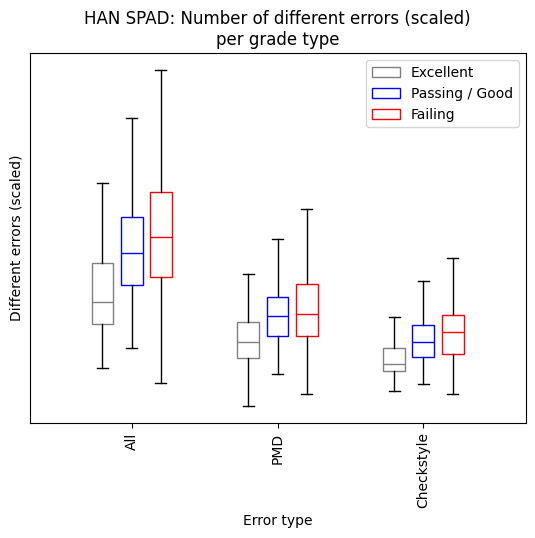

In [61]:
plot_boxes_grade_cats(abt_final, ['errors_count', 'pmd_count', 'checkstyle_count'],
           ['All', 'PMD', 'Checkstyle'],
           "HAN SPAD: Number of different errors (scaled)\nper grade type",
           'Error type',
           'Different errors (scaled)',
           hide_y = True
           )

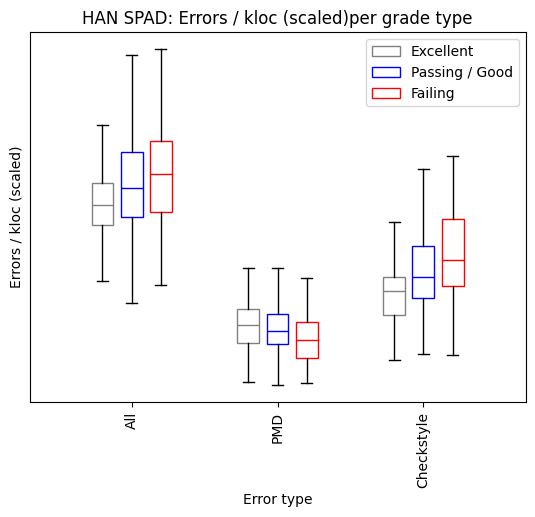

In [62]:
plot_boxes_grade_cats(abt_final, ['errors_total', 'pmd_total', 'checkstyle_total'],
           ['All', 'PMD', 'Checkstyle'],
           "HAN SPAD: Errors / kloc (scaled)per grade type",
           'Error type',
           'Errors / kloc (scaled)',
           hide_y = True
           )

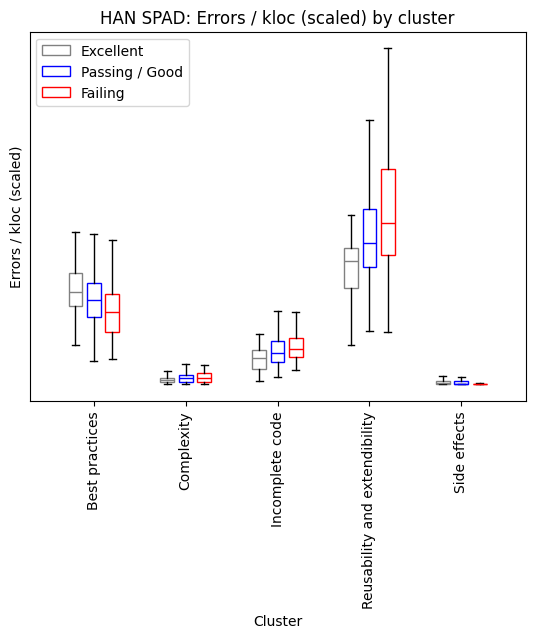

In [63]:
cluster_columns = [x for x in abt_final.columns if x.startswith("cluster_")]
labels = [x.replace('cluster_', '') for x in cluster_columns]


plot_boxes_grade_cats(abt_final,
           cluster_columns,
           labels,
           'HAN SPAD: Errors / kloc (scaled) by cluster',
           'Cluster',
           'Errors / kloc (scaled)',
           hide_y = True
           )

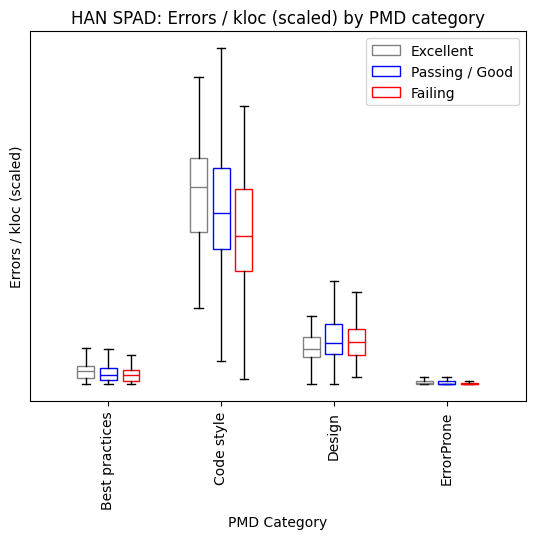

In [64]:
# Individual PMD categories
categories = [x for x in abt_final.columns if x.startswith('pmd_cat_')]
labels = [x.replace('pmd_cat_', '') for x in categories]

plot_boxes_grade_cats(abt_final,
    categories,
           labels,
           'HAN SPAD: Errors / kloc (scaled) by PMD category',
           'PMD Category',
           'Errors / kloc (scaled)',
           hide_y = True)

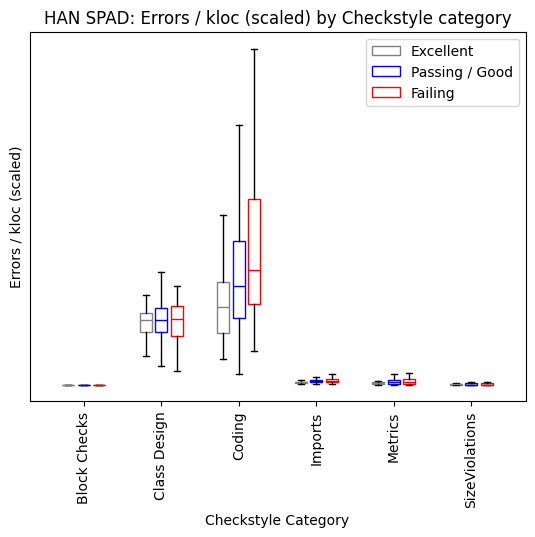

In [65]:
# Individual Checkstyle categories
categories = [x for x in abt_final.columns if x.startswith('checkstyle_cat_')]
labels = [x.replace('checkstyle_cat_', '') for x in categories]

plot_boxes_grade_cats(abt_final,
    categories,
           labels,
           'HAN SPAD: Errors / kloc (scaled) by Checkstyle category',
           'Checkstyle Category',
           'Errors / kloc (scaled)',
           hide_y = True)

/var/folders/zc/pfyjhy252g1fmlpp0765mxtm0000gn/T/ipykernel_61694/2496062823.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  abt_cats.loc[:, ('Design')] = abt_cats['checkstyle_cat_Class Design'] + abt_cats['pmd_cat_Design']


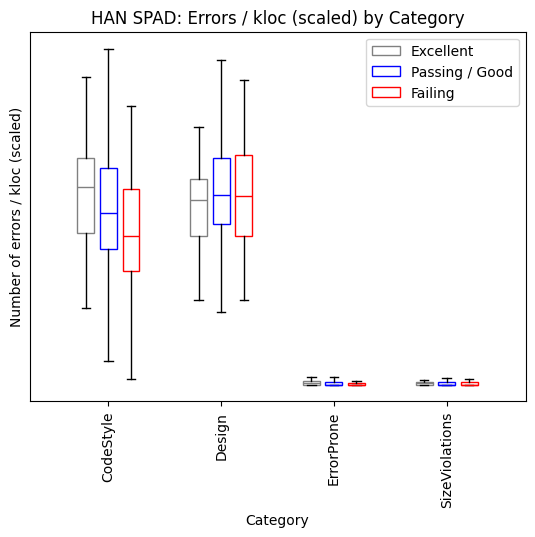

In [66]:
# Categories teachers were questioned on
# Individual PMD categories
abt_cats = abt_final[['grade', 
                      'checkstyle_cat_Class Design',
                      'checkstyle_cat_SizeViolations',
                      'pmd_cat_Design',
                      'pmd_cat_Code style',
                      'pmd_cat_ErrorProne',
                      ]]
abt_cats.loc[:, ('Design')] = abt_cats['checkstyle_cat_Class Design'] + abt_cats['pmd_cat_Design']
abt_cats = abt_cats.rename({
    'checkstyle_cat_SizeViolations': 'SizeViolations',
    'pmd_cat_Code style' : 'CodeStyle',
    'pmd_cat_ErrorProne' : 'ErrorProne'
}, axis = 1).drop(['checkstyle_cat_Class Design', 'pmd_cat_Design'], axis = 1)

categories = [x for x in abt_cats.columns if x != 'grade']
categories.sort()



plot_boxes_grade_cats(abt_cats,
    categories,
           categories,
           'HAN SPAD: Errors / kloc (scaled) by Category',
           'Category',
           'Number of errors / kloc (scaled)',
           hide_y = True)